In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
import torch 
import numpy as np
from pyscf import gto, scf
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh,eigs
import scipy.linalg as la
import scipy.sparse as sp


warnings.filterwarnings('ignore')

In [2]:
import argparse
from itertools import combinations

import numpy as np
from scipy.linalg import eigh

import cirq
from openfermion.ops import MajoranaOperator
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

import torch 


def factorial(n):
    if n == 1:
        return 1
    return n * factorial(n-1)

def get_couplings(N, var, L_inds, R_inds, seed, q):
    """Returns dictionaries of hamiltonian terms and their coefficients"""
    np.random.seed(seed)
    couplings = np.random.normal(scale=np.sqrt(var), size=len(L_inds))
    phase = (-1)**(q/2)
    J_L = {i: c for i, c in zip(L_inds, couplings)}
    J_R = {i: phase * c for i, c in zip(R_inds, couplings)}
    return J_L, J_R

def convert_H_majorana_to_qubit(inds, J_dict, N):
    """Convert SYK hamiltonian (dictionary) from majorana terms to Pauli terms"""
    ham_terms = [MajoranaOperator(ind, J_dict[ind]) for ind in inds]
    ham_sum = sum_ops(ham_terms)
    return jordan_wigner(ham_sum)

def q_helper(idx):
    """Returns qubit object based on index"""
    return cirq.LineQubit(idx)

def construct_pauli_string(ham, key):
    """Converts Pauli terms in the Hamiltonian to a string representation"""
    gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

    def list_of_terms(key):
        return [gate_dict[label](q_helper(idx)) for (idx, label) in key]

    return cirq.PauliString(ham.terms[key], list_of_terms(key))

def sum_ops(operators):
    """Wrapper for summing a list of majorana operators"""
    return sum(operators, MajoranaOperator((), 0))

def gs_energy(hamiltonian):
    """Use scipy to get the ground state energy"""
    from scipy.linalg import eigvalsh
    return eigvalsh(hamiltonian, eigvals=(0,0))

def main(N, seed, mu):
    q = 4 # setting q = N is all to all connectivity
    J = 1 # overall coupling strength

    J_var = 2**(q-1) * J**2 * factorial(q-1) / (q * N**(q-1))

    L_indices = range(0, N)
    R_indices = range(N, 2 * N)
    SYK_L_indices = list(combinations(L_indices, q))
    SYK_R_indices = list(combinations(R_indices, q))
    interaction_indices = [(l, r) for l, r in zip(L_indices, R_indices)]

    J_L, J_R = get_couplings(N, J_var, SYK_L_indices, SYK_R_indices, seed, q)
    interaction_strength = {ind: 1j * mu for ind in interaction_indices}

    H_L = convert_H_majorana_to_qubit(SYK_L_indices, J_L, N)
    H_R = convert_H_majorana_to_qubit(SYK_R_indices, J_R, N)
    H_int = convert_H_majorana_to_qubit(interaction_indices, interaction_strength, N)

    total_ham = H_L + H_R + H_int

    matrix_ham = get_sparse_operator(total_ham)
    return matrix_ham.todense()

N=8
seed= 0
mu= 0.01
hamiltonian_matrix = main(N,seed, mu)
hamiltonian_matrix= torch.tensor(hamiltonian_matrix)

print(hamiltonian_matrix)
print(len(hamiltonian_matrix))


tensor([[-0.7429+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j, -0.7970+0.0000j,  0.2495+0.0047j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.2495-0.0047j, -0.4701+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
        ...,
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.4701+0.0000j, -0.2495-0.0047j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
         -0.2495+0.0047j, -0.7970+0.0000j,  0.0000+0.0000j],
        [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j, -0.7429+0.0000j]],
       dtype=torch.complex128)
256


In [17]:
# Define the classical encoder neural network
class ClassicalEncoder(nn.Module):
    def __init__(self):
        super(ClassicalEncoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(256, 8),  # First layer with 7 inputs and 14 outputs
            nn.ReLU(),         # Activation function
            #nn.Linear(28, 56), # Second layer with 14 inputs and 28 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(56, 28), # Third layer with 28 inputs and 56 outputs
            #nn.ReLU(),         # Activation function
            #nn.Linear(28, 14), # Fourth layer reducing from 56 to 28 outputs
            #nn.ReLU(),         # Activation function
            nn.Linear(8, 4) # Fifth layer reducing from 28 to 14 outputs
        )
    
    def forward(self, x):
        return self.fc(x)

encoder = ClassicalEncoder()
#print("The encoder is: ", encoder)

# Define a function to execute the quantum circuit
def run_quantum_circuit(params):
    # Create a list of parameters for the quantum circuit
    theta = [Parameter(f'θ{i}') for i in range(4)]

    # add control rotation gates
    
    # Create a quantum circuit with 4 qubits and 4 classical bits
    qc = QuantumCircuit(4)
    
    # Apply initial Ry and Rx rotations
    for i in range(4):
        qc.rz(theta[i], i)
        qc.rx(theta[i], i)
        qc.rz(theta[i], i)

    qc.barrier()


    for i in range(4):
        qc.rxx(theta[i],0,1)
        qc.rxx(theta[i],1,2)
        qc.rxx(theta[i],2,3)
        qc.rxx(theta[i],0,3)
    

    qc.barrier()
    
    

    # Add measurements to all qubits
    qc.measure_all()
    
    # Bind the parameters to the values from the PyTorch model
    param_dict = {theta[i]: params[i].item() for i in range(4)}
    qc_bound = qc.bind_parameters(param_dict)
    
    # Print the quantum circuit
    #print(qc_bound)

    # If you want a visual diagram of the circuit, you can use:
    # circuit_drawer(qc_bound, output='mpl').show()

    # Execute the quantum circuit
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc_bound, backend, shots=1024)
    result = job.result()
    counts = result.get_counts(qc_bound)
    
    # Plot the histogram of results
    plot_histogram(counts)
    
    # Get the most common bitstring
    output_bitstring = max(counts, key=counts.get)
    
    # Convert bitstring to numpy array of integers
    output_data = np.array([int(bit) for bit in output_bitstring])
    
    # Convert to PyTorch tensor
    output_tensor = torch.tensor(output_data, dtype=torch.float32)
    
    return output_tensor

# Define the classical decoder neural network
class ClassicalDecoder(nn.Module):
    def __init__(self):
        super(ClassicalDecoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 8),    # First layer with 4 inputs and 8 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(8, 16),   # Second layer with 8 inputs and 16 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(16, 32),  # Third layer with 16 inputs and 32 outputs
            #nn.ReLU(),          # Activation function
            #nn.Linear(32, 64),
            #nn.ReLU(),
            #nn.Linear(64, 32),  # Fourth layer reducing from 32 to 16 outputs
            nn.ReLU(),          # Activation function
            nn.Linear(8, 256)
        )
    
    def forward(self, x):
        return self.fc(x)

decoder = ClassicalDecoder()
#print("The decoder is: ", decoder)


class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.encoder = ClassicalEncoder()
        self.decoder = ClassicalDecoder()
        self.qcircuit = run_quantum_circuit

    def forward(self, x):
        encoded = self.encoder(x)
        quantum_result = self.qcircuit(encoded)
        decoded = self.decoder(quantum_result)
        return decoded

# Initialize the model
model = HybridModel()



In [18]:
def energy_expectation(output, hamiltonian):
    # ... [previous code] ...

    # Convert hamiltonian to double
    hamiltonian = hamiltonian.type(torch.double)

    # Convert output to double
    wavefunction = output.type(torch.double)

    # Normalize the wavefunction
    norm_wavefunction = wavefunction / torch.sqrt(torch.sum(torch.abs(wavefunction)**2))

    # Calculate the energy expectation value
    energy = torch.vdot(norm_wavefunction, torch.mv(hamiltonian, norm_wavefunction)).real

    return energy


In [19]:
# Sample input
input_data = torch.rand(256, requires_grad=True)  # Example input
#input_data= torch.tensor([ 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241, 0.3679, -0.0602,  0.6200,  0.1083, -0.0054,  0.0107,  0.1241])

# Optimization setup
#print("The model parameters are: ", model.parameters)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000
loss_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()            # Clear existing gradients
    output = model(input_data)       # Forward pass

    # Ensure output requires grad
    if not output.requires_grad:
        raise RuntimeError("Output does not require gradients. Check model implementation.")

    # Calculate the loss
    #initial_hamiltonian = hamiltonian_initial_module.mf.get_hcore()
    #final_hamiltonian = hamiltonian_final_module.mf.get_hcore()
    loss = energy_expectation(output,hamiltonian_matrix)
    # Check if loss requires grad
    if not loss.requires_grad:
        raise RuntimeError("Loss does not require gradients. Check energy_expectation implementation.")

    loss.backward()                  # Backward pass
    optimizer.step()                 # Update parameters
    loss_values.append(loss.item())  # Store loss for plotting
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


Epoch 1/1000, Loss: -0.07947386451278216
Epoch 2/1000, Loss: -0.2821504620744902
Epoch 3/1000, Loss: -0.4692430215276377
Epoch 4/1000, Loss: -0.6376005955087714
Epoch 5/1000, Loss: -0.7867024207118654
Epoch 6/1000, Loss: -0.9179707820560092
Epoch 7/1000, Loss: -1.0334117680072317
Epoch 8/1000, Loss: -1.135409412256267
Epoch 9/1000, Loss: -1.2263029134503616
Epoch 10/1000, Loss: -1.308045926772321
Epoch 11/1000, Loss: -1.3821906426007802
Epoch 12/1000, Loss: -1.4499102032265754
Epoch 13/1000, Loss: -1.5120720889191515
Epoch 14/1000, Loss: -1.5693563789224376
Epoch 15/1000, Loss: -1.6223384793061555
Epoch 16/1000, Loss: -1.6715352380972326
Epoch 17/1000, Loss: -1.7174269414777412
Epoch 18/1000, Loss: -1.7604692056719555
Epoch 19/1000, Loss: -1.801099294310992
Epoch 20/1000, Loss: -1.8397328707364513
Epoch 21/1000, Loss: -1.8767508010882963
Epoch 22/1000, Loss: -1.9124840010846866
Epoch 23/1000, Loss: -1.9472050069689222
Epoch 24/1000, Loss: -1.981126402989594
Epoch 25/1000, Loss: -2.0144

In [20]:
import scipy.linalg as la

def find_lowest_eigenvalue(matrix):
    # Compute all eigenvalues, but only the first eigenvectors
    eigenvalues, _ = la.eigh(matrix, eigvals=(0, 0))
    return eigenvalues[0]

# Assuming large_matrix is your matrix
lowest_eigenvalue = find_lowest_eigenvalue(hamiltonian_matrix)
print("Lowest Eigenvalue:", lowest_eigenvalue)


Lowest Eigenvalue: -5.315575141437583


In [ ]:
# for the no pqc ground state approximation was: -4.239352522251876
# for the pqc ground state: -4.253164531632698


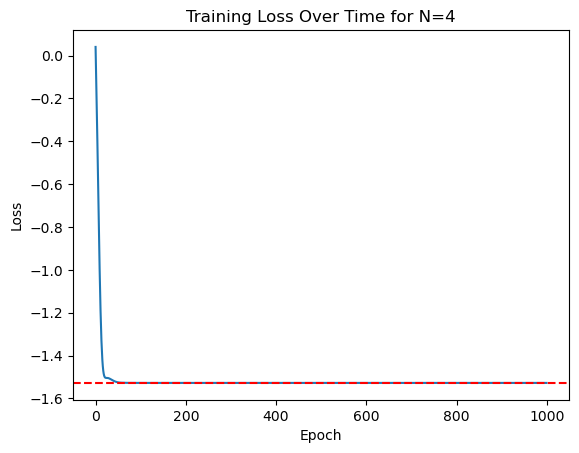

In [15]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=4')
plt.show()

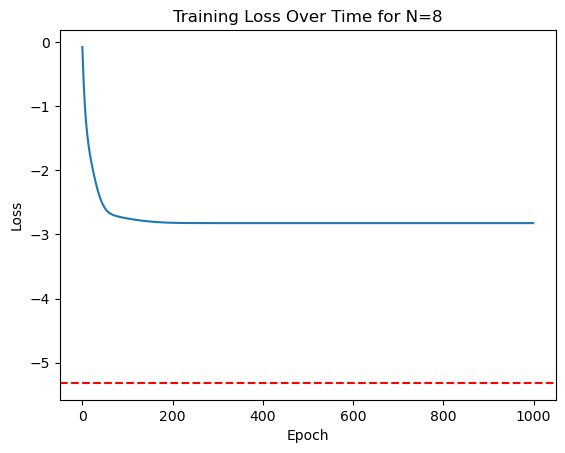

In [21]:
# Plotting the loss values
plt.plot(loss_values)
plt.axhline(y=lowest_eigenvalue, color='r', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time for N=8')
plt.show()